Exploring the deep fields

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from photometric_models import HG, HG12, HG1G2
from db import query
from dr_downloader import survey_years
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time


plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}


In [2]:
ddfs = {
    "ELAIS S1": {"el": 345.97, "eb": -43.18},
    "XMM-LSS": {"el": 31.04, "eb": -17.90},
    "Extended Chandra Deep Field-South": {"el": 40.29, "eb": -45.47	},
    "COSMOS": {"el": 150.70, "eb":  -9.39}
} # https://www.lsst.org/scientists/survey-design/ddf #

deep_fields = {
    "ELAIS S1": {"ra2000": "00 37 48", "dec2000": "-44 00 00"},
    "XMM-LSS": {"ra2000": "02 22 50", "dec2000": "-04 45 00"},
    "Extended Chandra Deep Field-South": {"ra2000":"03 32 30", "dec2000": "-28 06 00"},
    "COSMOS": {"ra2000": "10 00 24", "dec2000": "+02 10 55"},
    "EUCLID SOUTH": {"ra2000": "04 04 57", "dec2000": "-48 25 22"},
    "EUCLID NORTH": {"ra2000": "17 58 55", "dec2000": "+66 01 03"}
}

In [5]:
objs = query(
    '''
    SELECT ssObjectId FROM dp03_catalogs_10yr.SSObject as sso WHERE numObs >= 2000
    '''
).to_table().to_pandas()

In [5]:
objs_detections = query(
    f'''
    SELECT eclipticLambda, eclipticBeta, ssObjectId FROM dp03_catalogs_10yr.SSSource as sss WHERE sss.ssObjectId IN {tuple(objs["ssObjectId"].to_list())}
    '''
).to_table().to_pandas()

In [37]:
objs_detections.to_csv("./high_objs_detections_coords.csv")

In [3]:
objs_detections = pd.read_csv("./high_objs_detections_coords.csv", index_col=False).drop(columns=["Unnamed: 0"])

In [6]:
ddf_objs = query(
    f'''
    SELECT ssObjectId, eclipticLambda, eclipticBeta, ssObjectId FROM dp03_catalogs_10yr.SSSource as sss WHERE sss.ssObjectId IN {tuple(objs["ssObjectId"].to_list())}
    '''
).to_table().to_pandas()

Text(0, 0.5, 'Ecliptic beta [deg]')

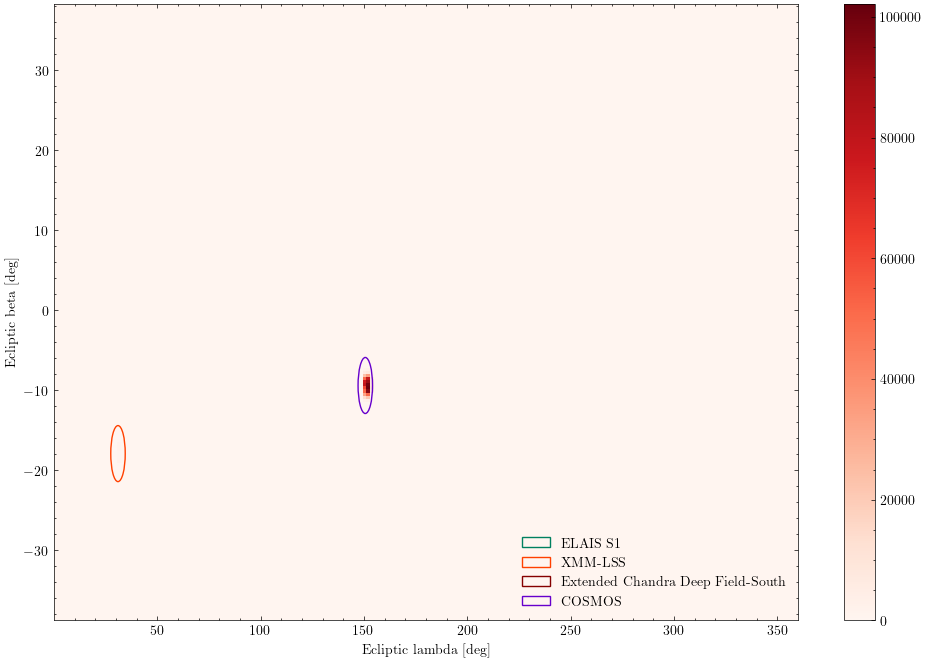

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

h = ax.hist2d(
    objs_detections["eclipticLambda"],
    objs_detections["eclipticBeta"],
    bins=200,
    cmap=mpl.colormaps['Reds']
)
fig.colorbar(h[3], ax=ax)


for i, (ddf, coord) in enumerate(ddfs.items()):
    ax.add_patch(
        plt.Circle((coord["el"], coord["eb"]), 3.5, label=ddf, facecolor="none", edgecolor=list(filter_colors.values())[i])
    )

plt.legend(loc="lower right")
plt.xlabel(
    "Ecliptic lambda [deg]"
)
plt.ylabel(
    "Ecliptic beta [deg]"
)

In [9]:
# For each observation, is this in a deep drilling field?

# Is the ecliptic co-ord within 3.5 deg of x and y

def ddf_distance(field, el, eb):
    return np.sqrt((ddfs[field]["el"] - el)**2 + (ddfs[field]["eb"] - eb)**2)

def check_in_ddf(el, eb):
    for ddf, coords in ddfs.items():
        d = np.sqrt((coords["el"] - el)**2 + (coords["eb"] - eb)**2)
        if d <= 3.5:
            return True
    return False

count = 0
for i in range(len(objs_detections)):
    if check_in_ddf(el = objs_detections.iloc[i]["eclipticLambda"], eb=objs_detections.iloc[i]["eclipticBeta"]):
        count +=1

count

1059640

In [57]:
print(f"{count} object observations from the highly observed object detections are discovered in deep fields, that is {round(100*count/len(objs_detections),2)}% of these object's observations")

1059640 object observations from the highly observed object detections are discovered in deep fields, that is 87.16% of these object's observations


What about the other 13%?

In [16]:
for FIELD in ddfs:
    objs_detections[f"{FIELD}_distance"] = ddf_distance(field=FIELD, el = objs_detections["eclipticLambda"], eb = objs_detections["eclipticBeta"])
    objs_detections[f"in_{FIELD}"] =  objs_detections[f"{FIELD}_distance"] <= 3.5

In [21]:
for FIELD in ddfs:
    print(f'{objs_detections[f"in_{FIELD}"].sum()} in {FIELD}')

0 in ELAIS S1
22713 in XMM-LSS
0 in Extended Chandra Deep Field-South
1036927 in COSMOS


In [50]:
objs_detections["in_any_field"] = objs_detections["in_COSMOS"] + objs_detections["in_XMM-LSS"] + objs_detections["in_Extended Chandra Deep Field-South"] + objs_detections["in_ELAIS S1"]

In [67]:
x = objs_detections.groupby("ssObjectId")
print(f'{(x["in_any_field"].sum() == 0).sum()} objects have zero detections in the deep field.')
# All have at least one observation in the deep fields.

0 objects have zero detections in the deep field.


Orbital elements of these objects

In [111]:
obj_orbital_elements = query(
    f'''
    SELECT q/(1-e) as a, q, incl, e FROM  dp03_catalogs_10yr.MPCORB as mpc WHERE ssObjectId IN {tuple(objs["ssObjectId"].to_list())}

    '''
).to_table().to_pandas()

Text(0, 0.5, 'incl [deg]')

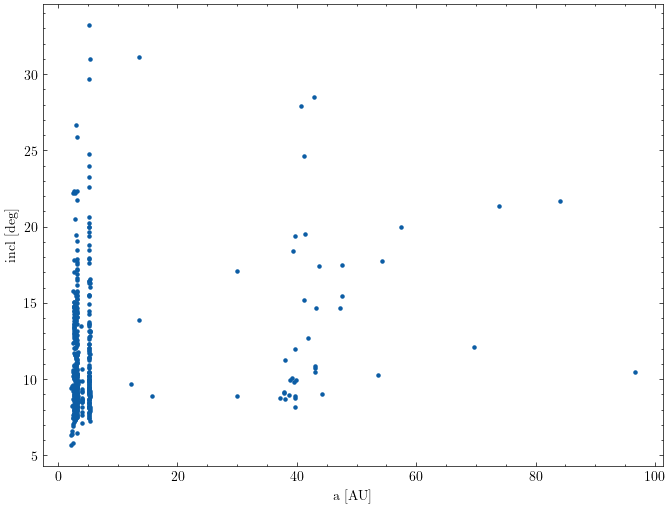

In [120]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(
    obj_orbital_elements["a"].astype(float),
    obj_orbital_elements["incl"].astype(float),
    s=5
)
ax.set_xlabel("a [AU]")
ax.set_ylabel("incl [deg]")

Text(0, 0.5, 'incl [deg]')

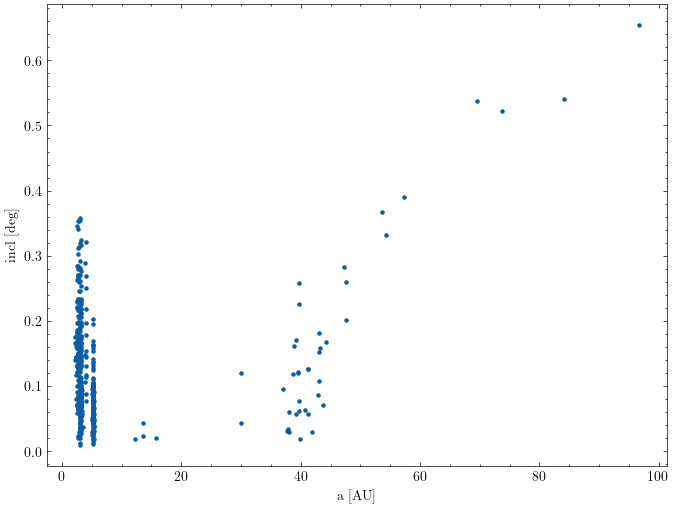

In [121]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(
    obj_orbital_elements["a"].astype(float),
    obj_orbital_elements["e"].astype(float),
    s=5
)
ax.set_xlabel("a [AU]")
ax.set_ylabel("incl [deg]")

ELAIS S1
---


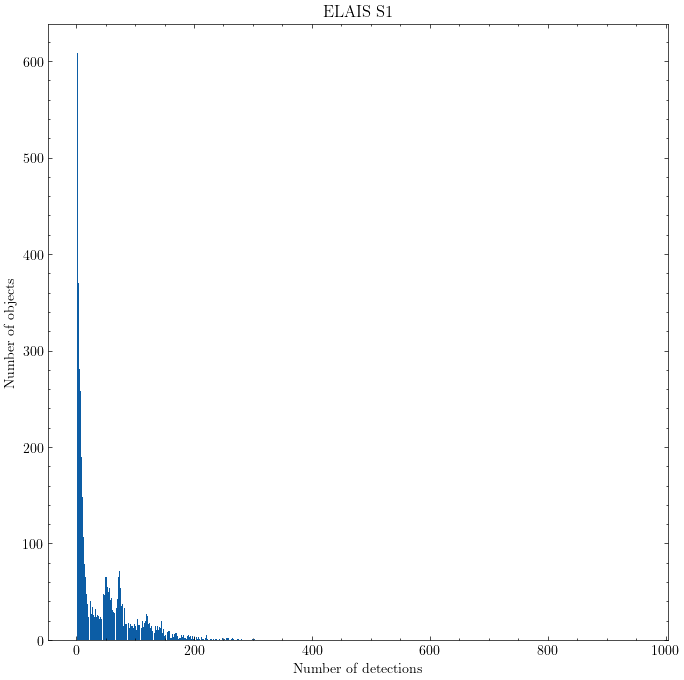

XMM-LSS
---


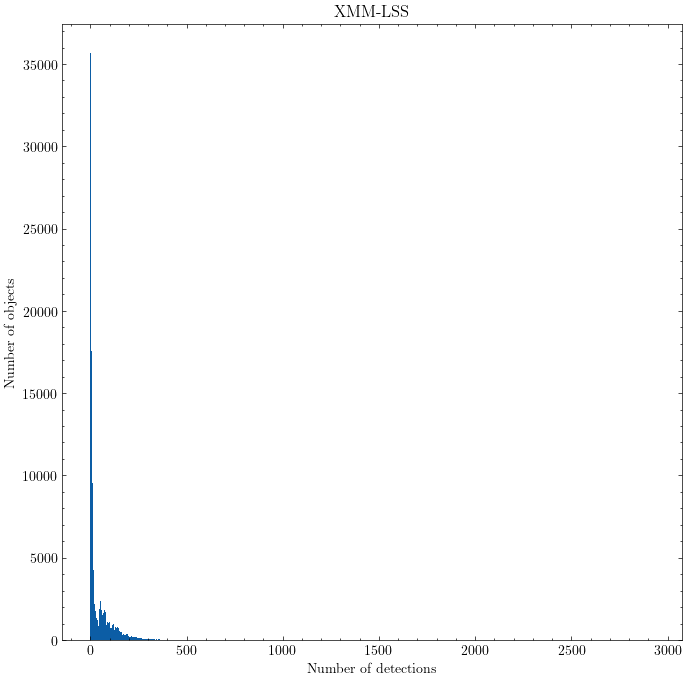

Extended Chandra Deep Field-South
---


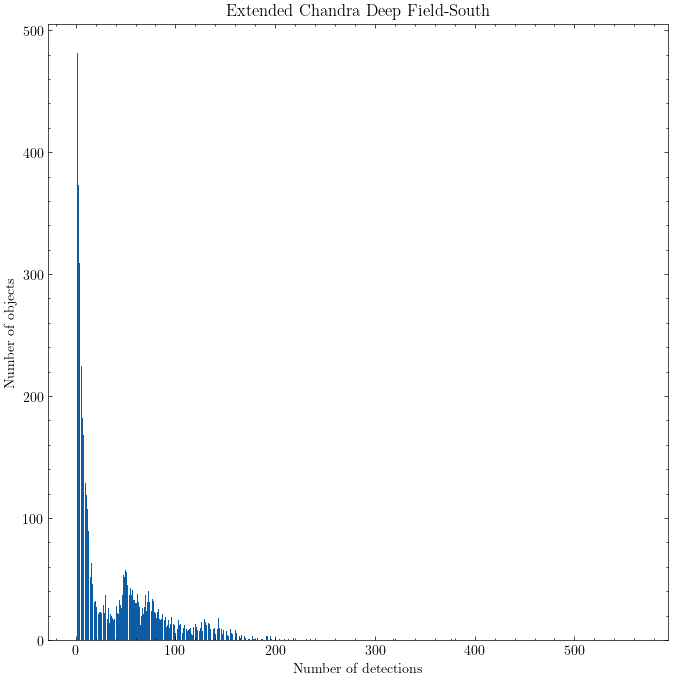

COSMOS
---


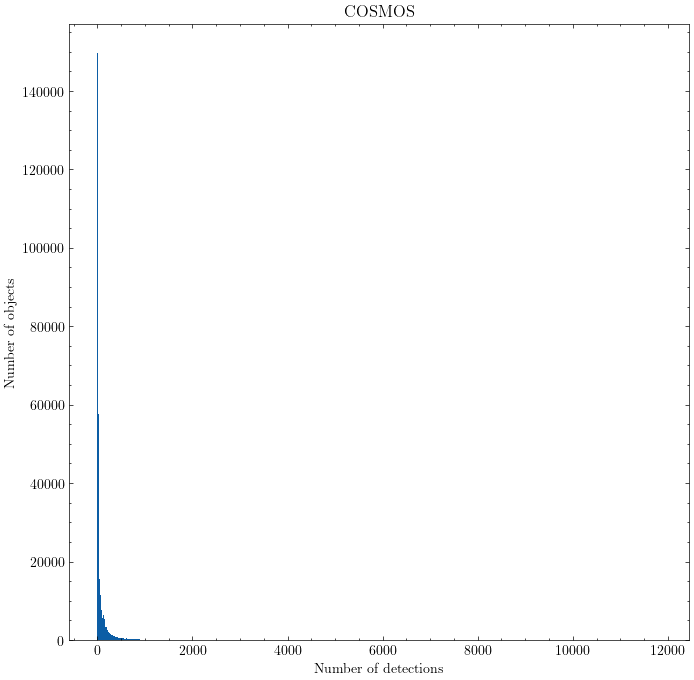

EUCLID SOUTH
---


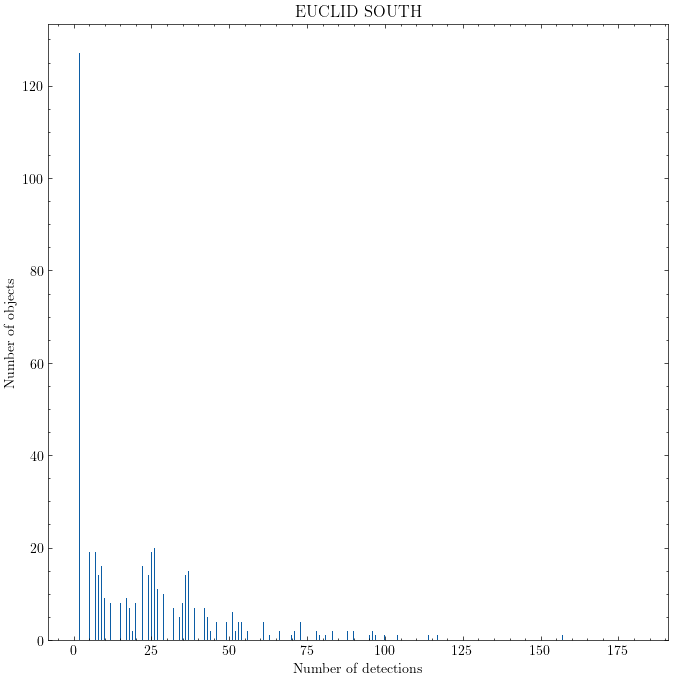

EUCLID NORTH
---


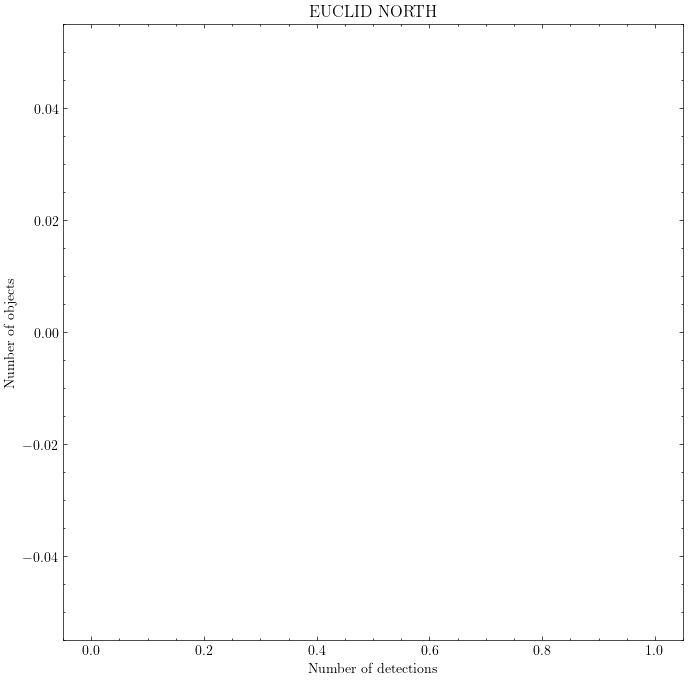

In [65]:
for name, field in deep_fields.items():
    c = SkyCoord(field["ra2000"], field["dec2000"], frame='icrs', unit=(u.hourangle, u.deg))
    print(name)
    print("---")
    stmt = f'''SELECT ssObjectId, count(ssObjectId)
    FROM dp03_catalogs_10yr.DiaSource as ds
    WHERE CONTAINS(POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {c.ra.degree}, {c.dec.degree}, 3.5)) = 1
    GROUP BY ssObjectId
    '''

    df = query(stmt).to_table().to_pandas()

    plt.figure(figsize=(8,8))
    plt.hist(
        df["count"],
        bins=1000
    )

    plt.title(f"{name}")
    plt.xlabel("Number of detections")
    plt.ylabel("Number of objects")
    plt.show()

    del df

In [9]:
years = survey_years() # cache this

bands = np.array([["g", "r", "i", "z"] for i in range(len(years))]).reshape(1, 4*len(years)).tolist()[0]

catalog_delta = years[0].value[1][0] - years[0].value[0][0] # Time epoch for first year catalog
catalog_dates = []
catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0]], format="mjd"))

for i in range(1, 8):
    catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0] + (i)*catalog_delta], format="mjd"))
catalog_dates.append(Time([years[0].value[0][0], \
                years[-1].value[1][0]], format="mjd"))

ELAIS S1
---


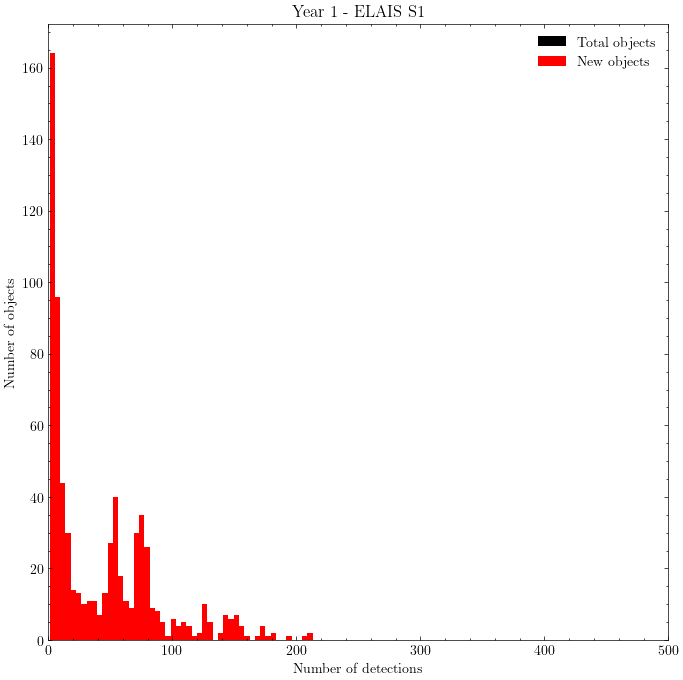

ELAIS S1
---


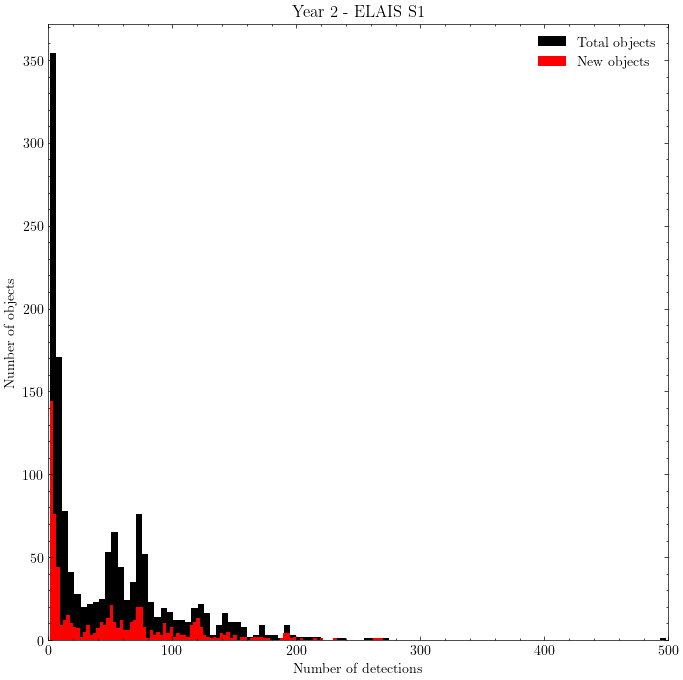

ELAIS S1
---


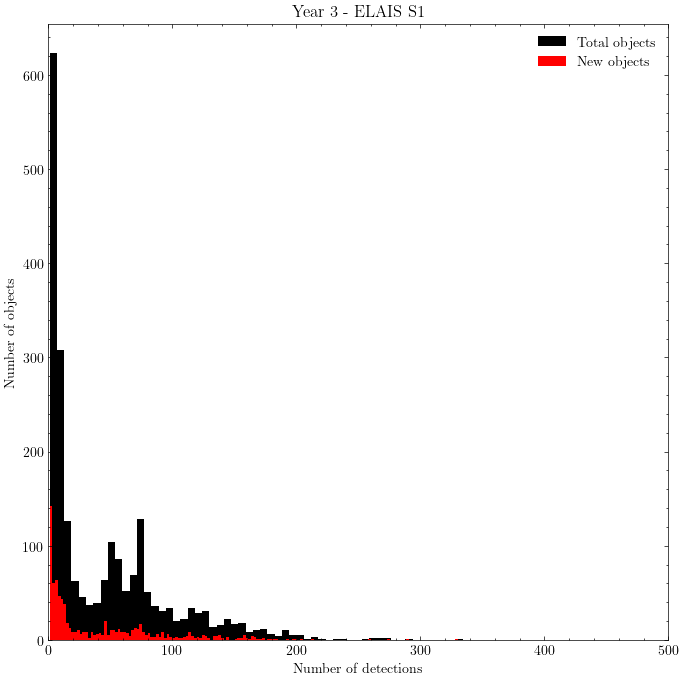

ELAIS S1
---


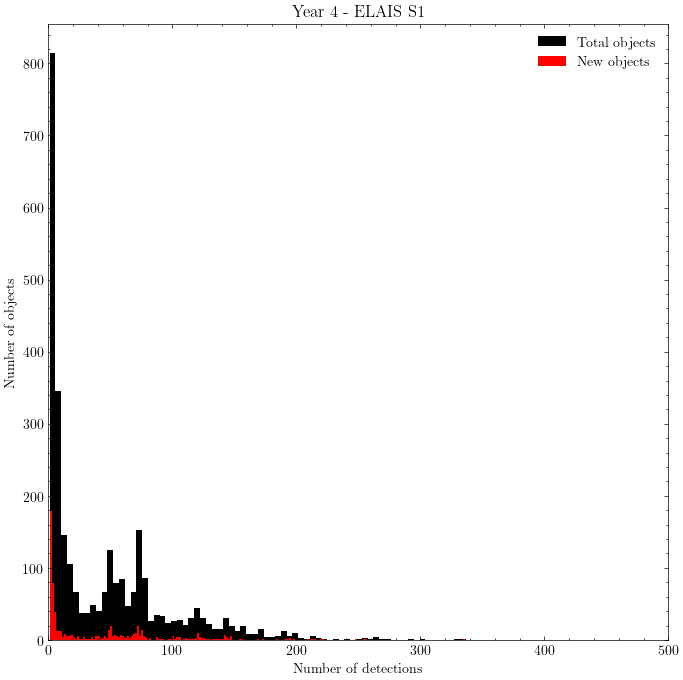

ELAIS S1
---


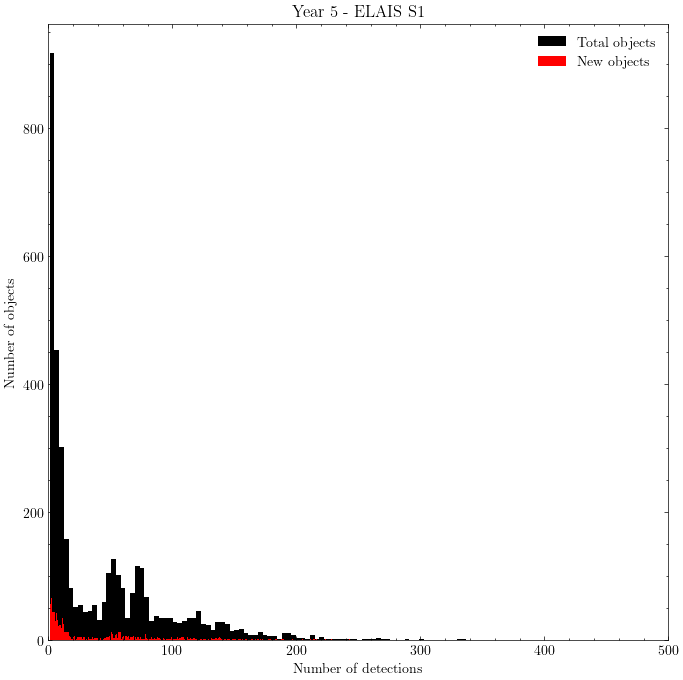

ELAIS S1
---


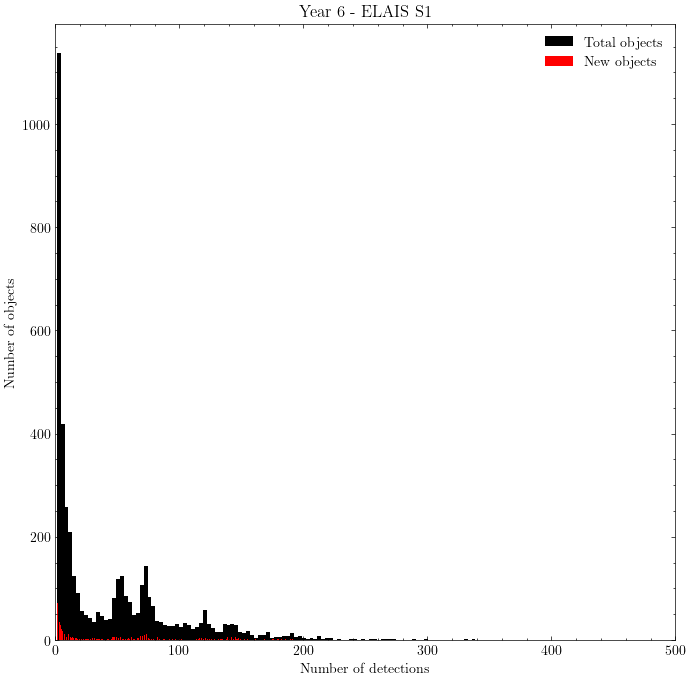

ELAIS S1
---


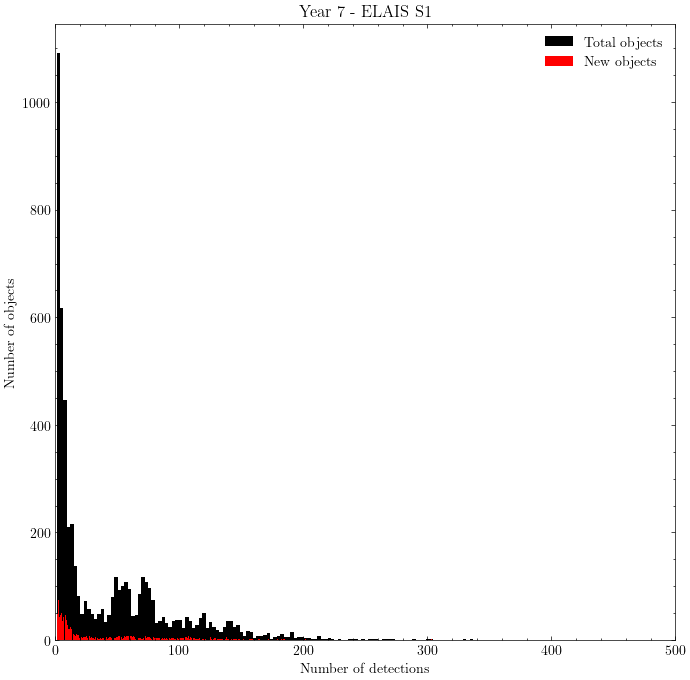

ELAIS S1
---


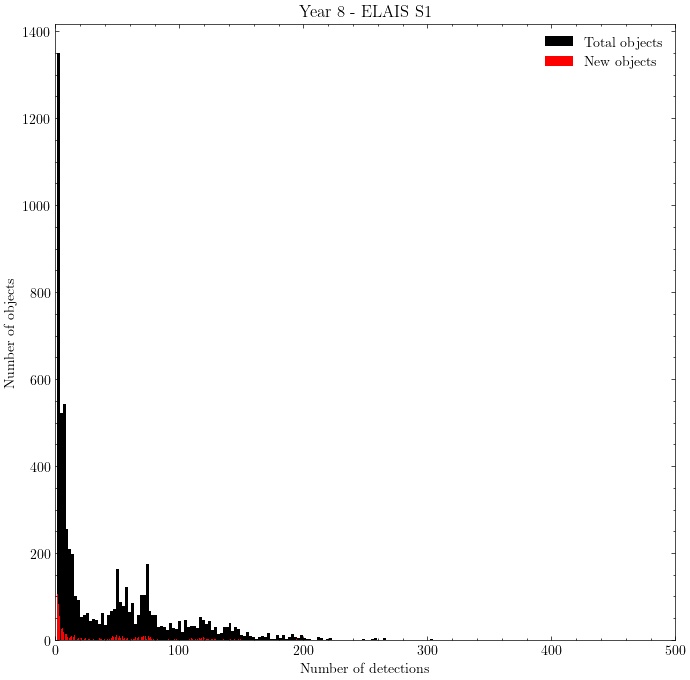

ELAIS S1
---


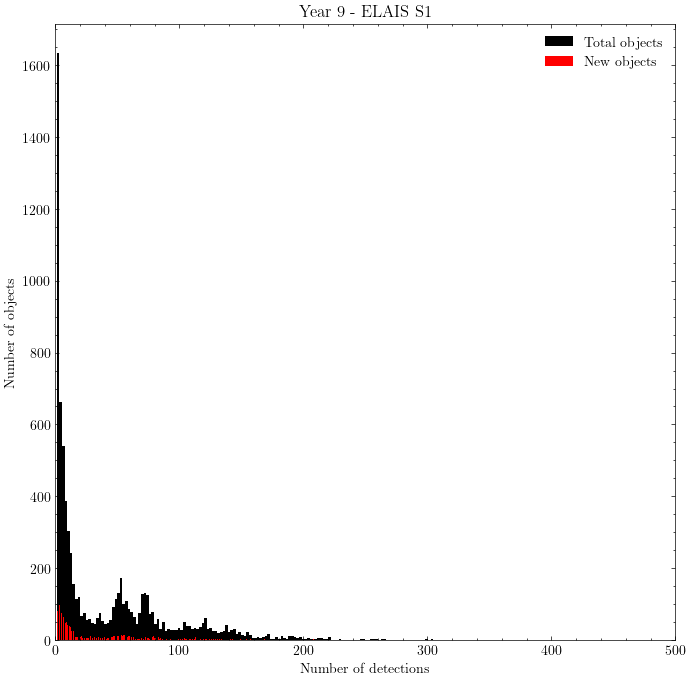

XMM-LSS
---


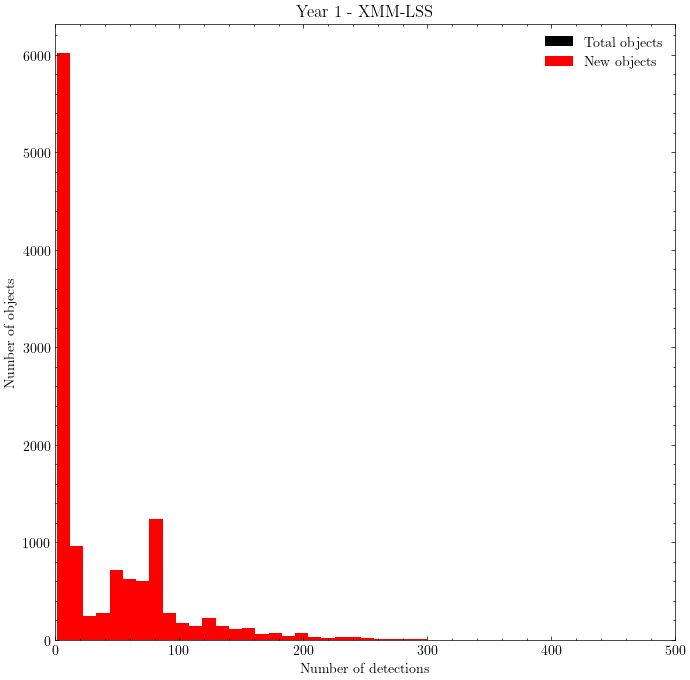

XMM-LSS
---


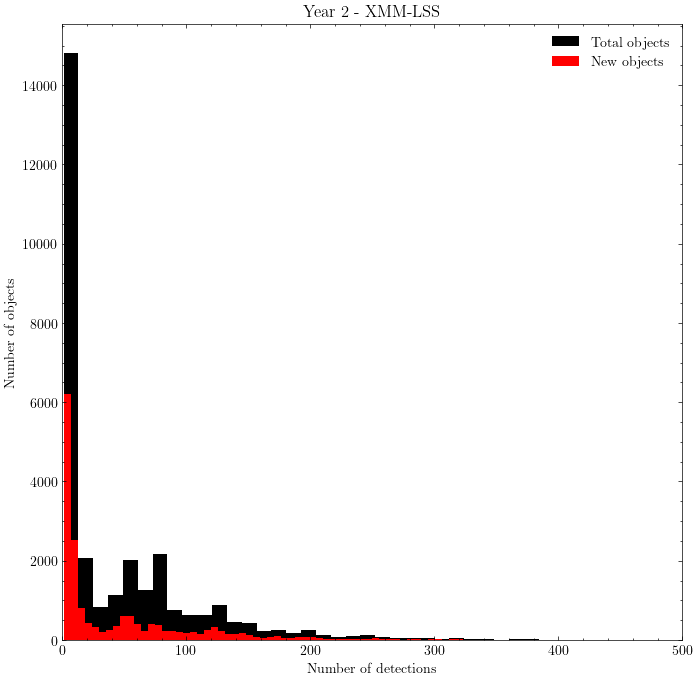

XMM-LSS
---


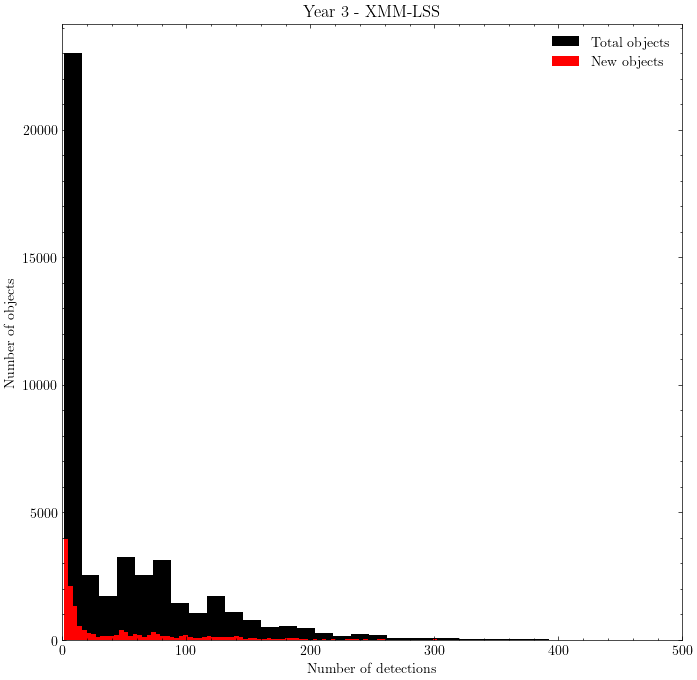

XMM-LSS
---


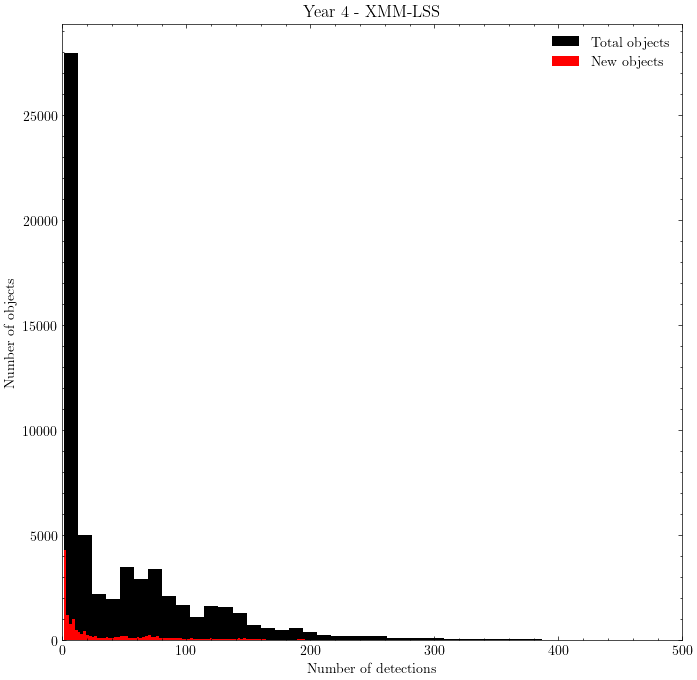

XMM-LSS
---


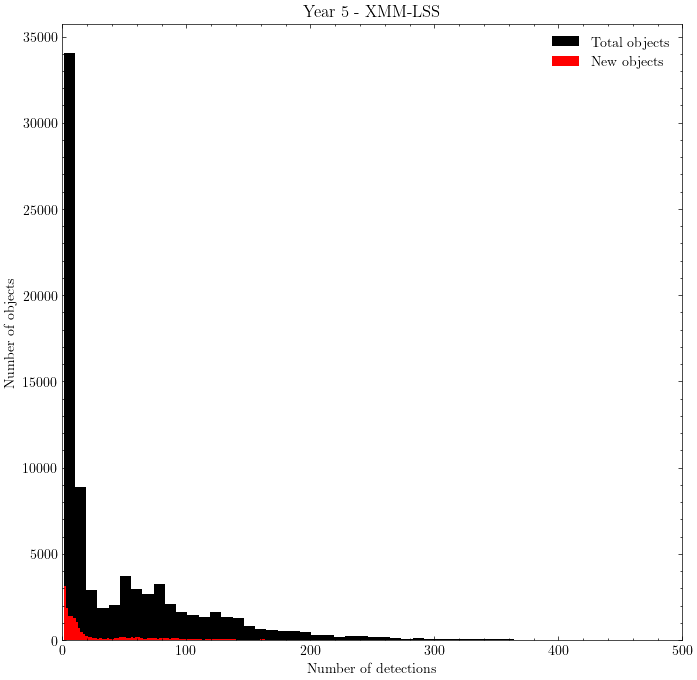

XMM-LSS
---


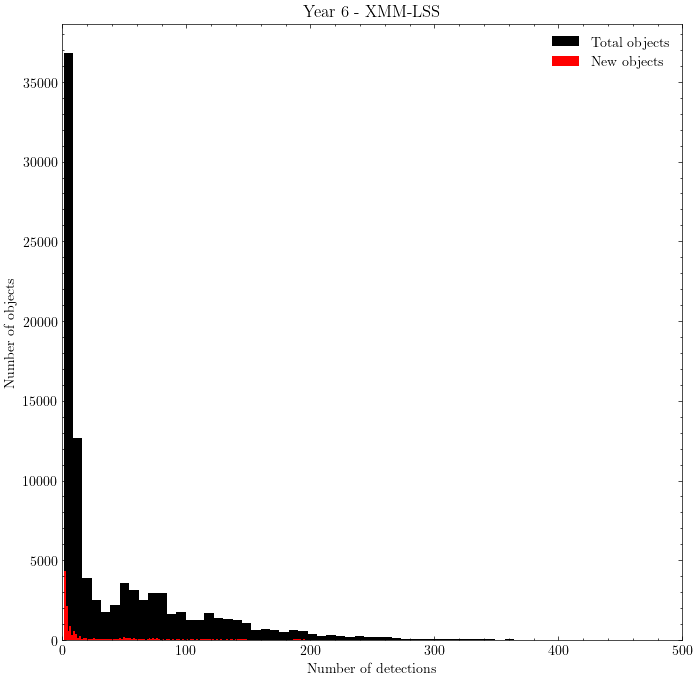

XMM-LSS
---


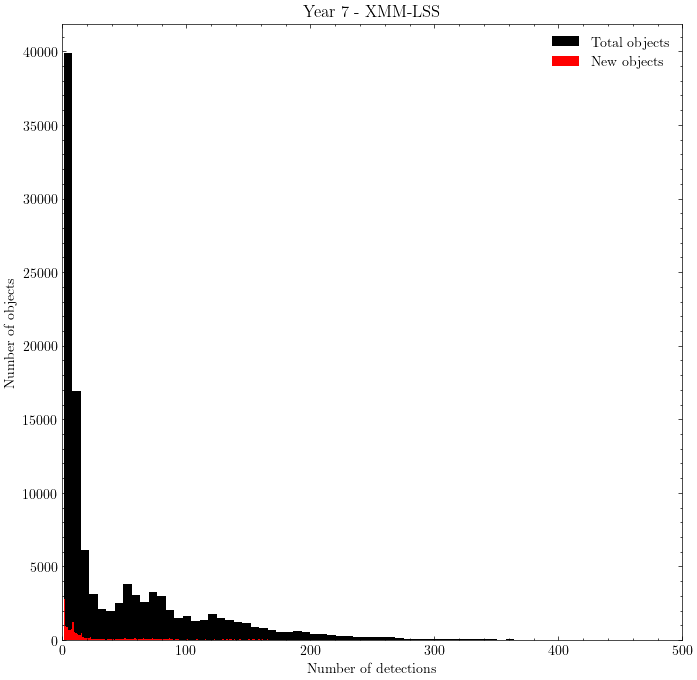

XMM-LSS
---


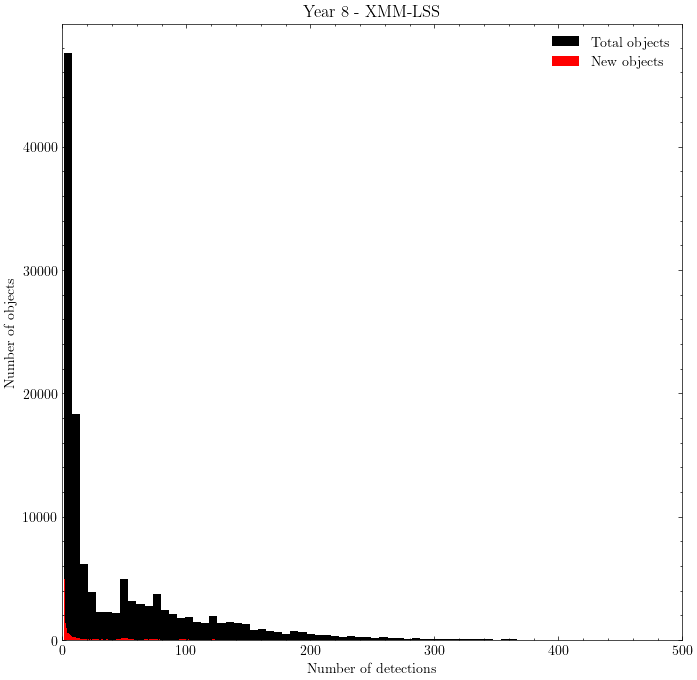

XMM-LSS
---


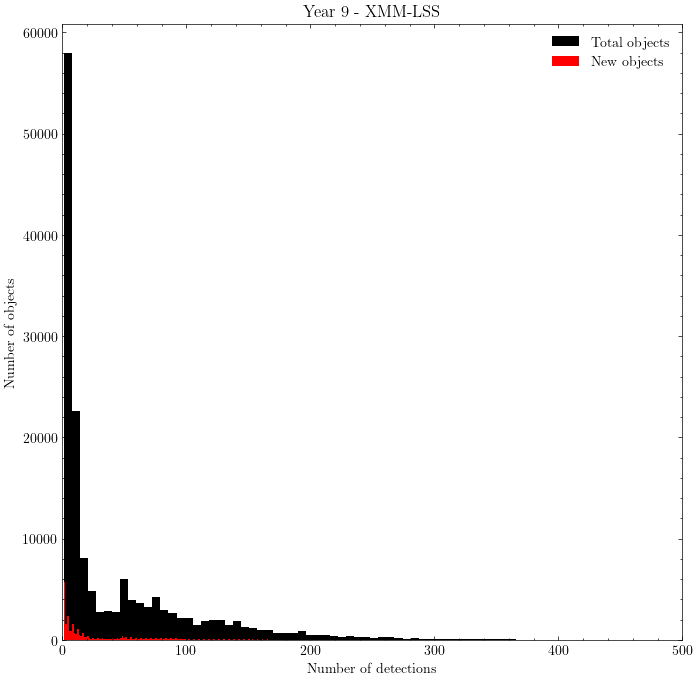

Extended Chandra Deep Field-South
---


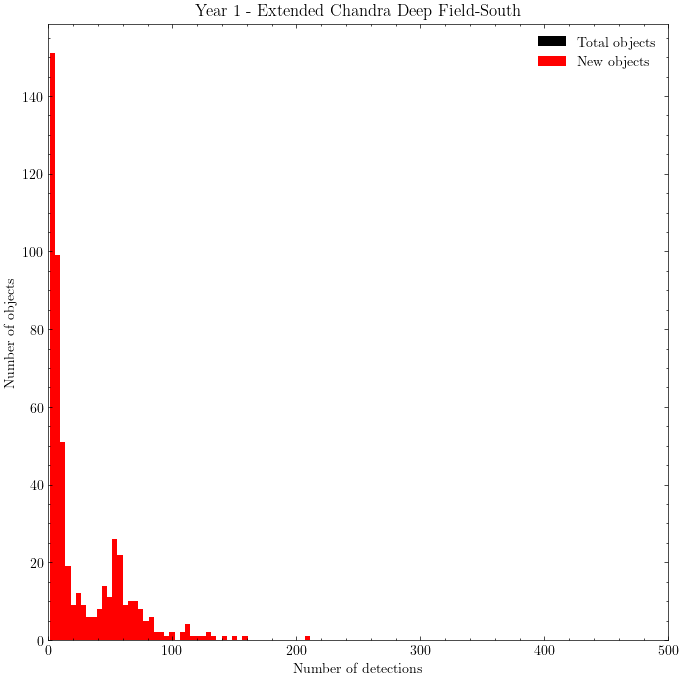

Extended Chandra Deep Field-South
---


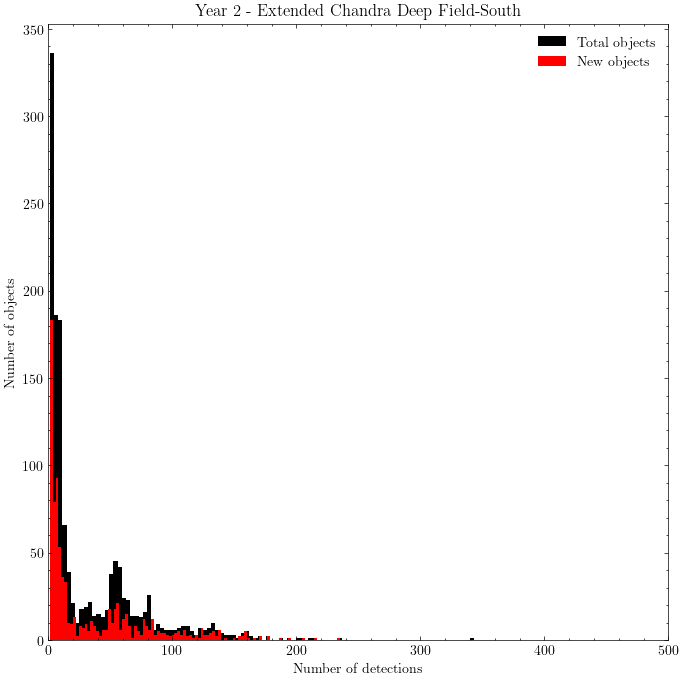

Extended Chandra Deep Field-South
---


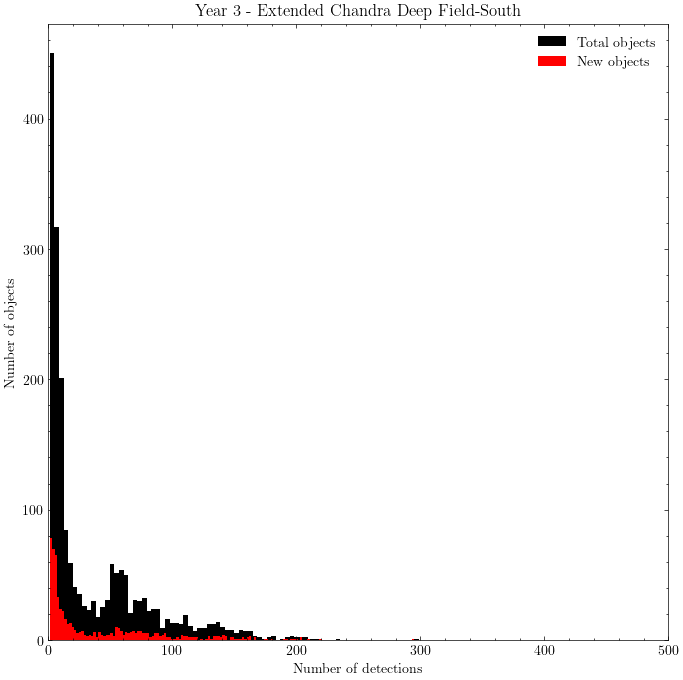

Extended Chandra Deep Field-South
---


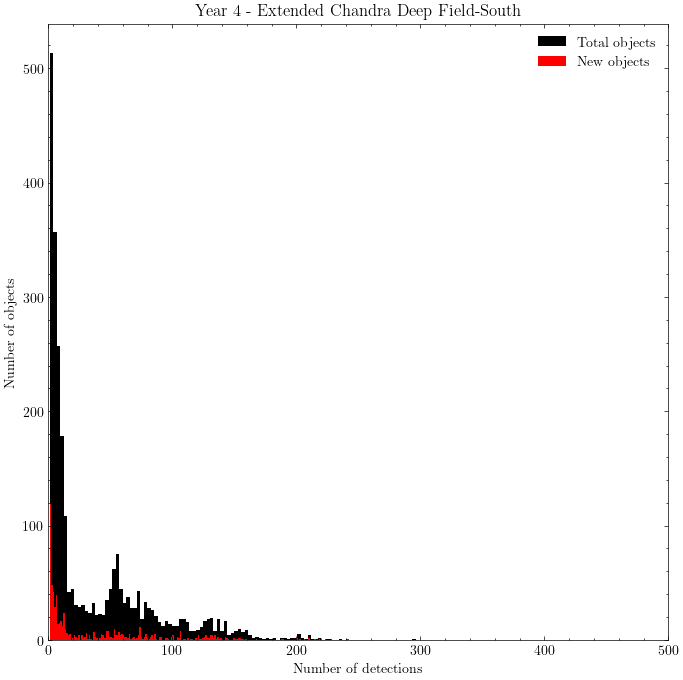

Extended Chandra Deep Field-South
---


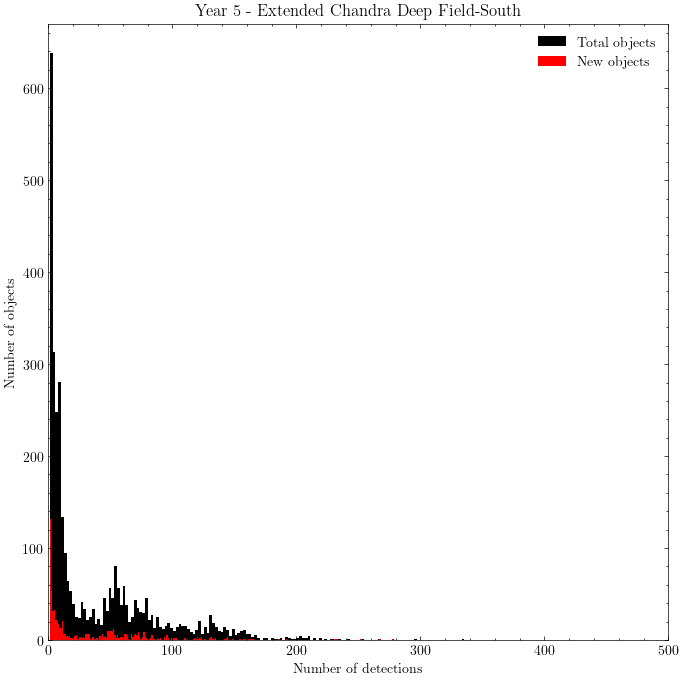

Extended Chandra Deep Field-South
---


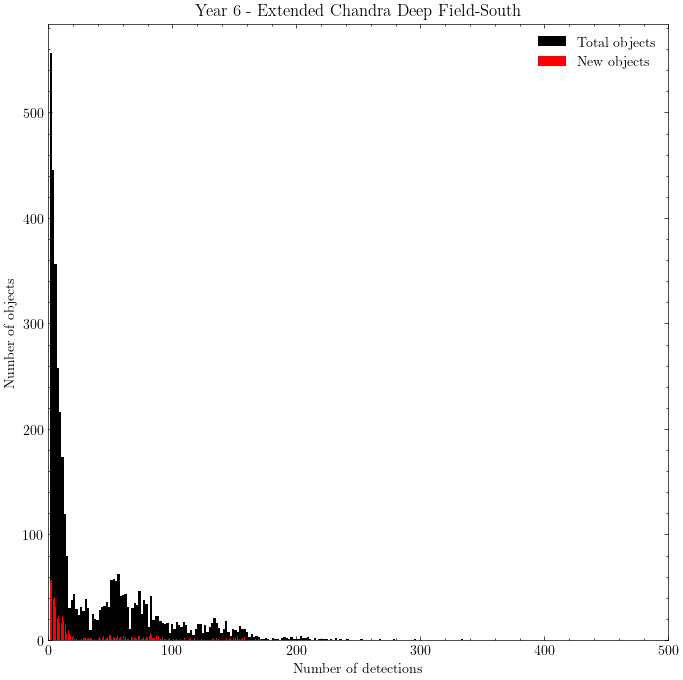

Extended Chandra Deep Field-South
---


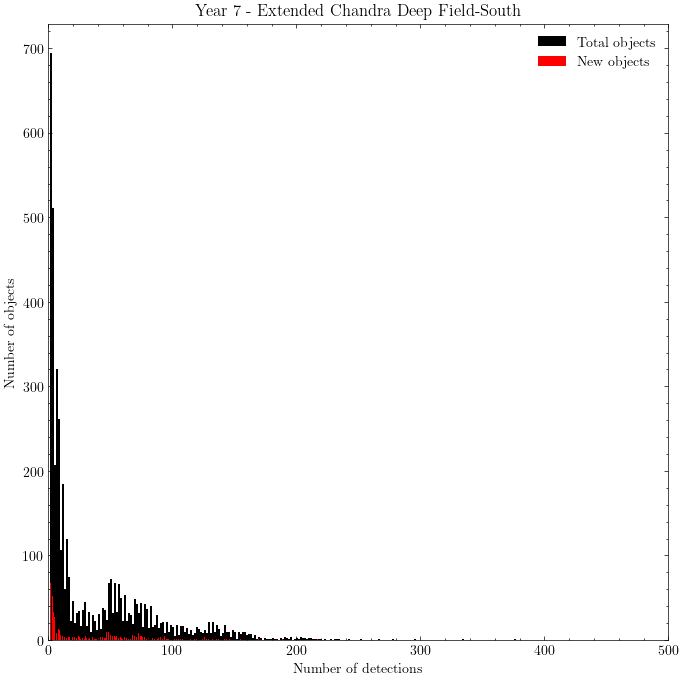

Extended Chandra Deep Field-South
---


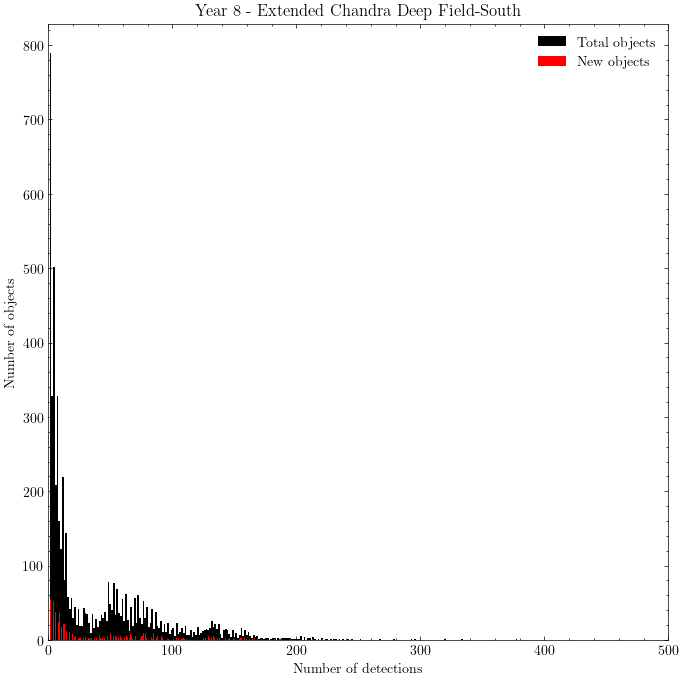

Extended Chandra Deep Field-South
---


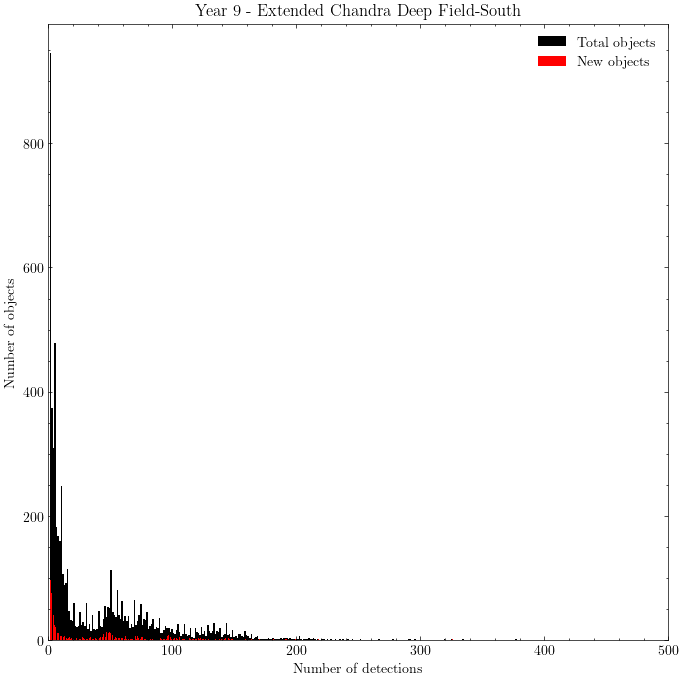

COSMOS
---


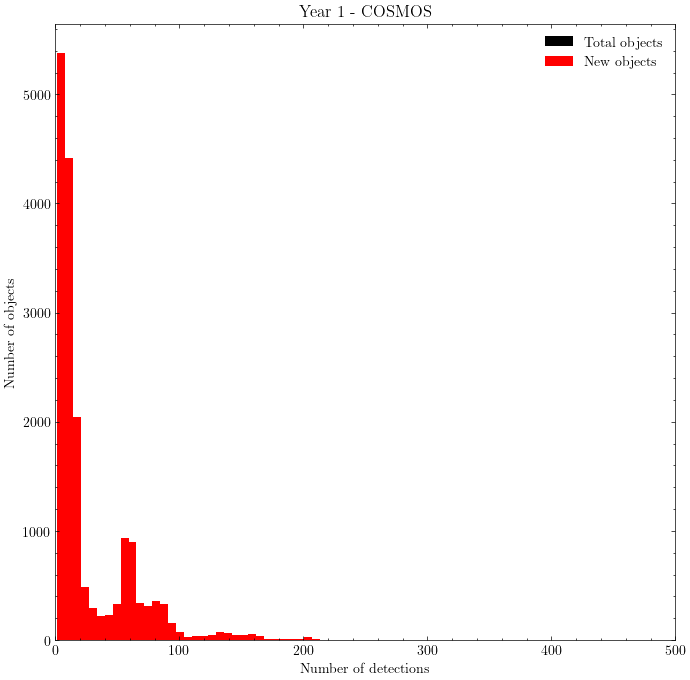

COSMOS
---


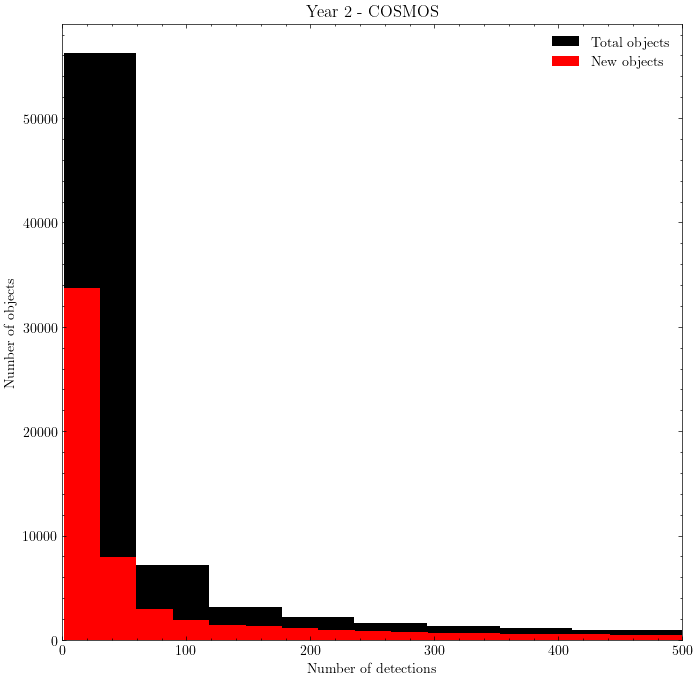

COSMOS
---


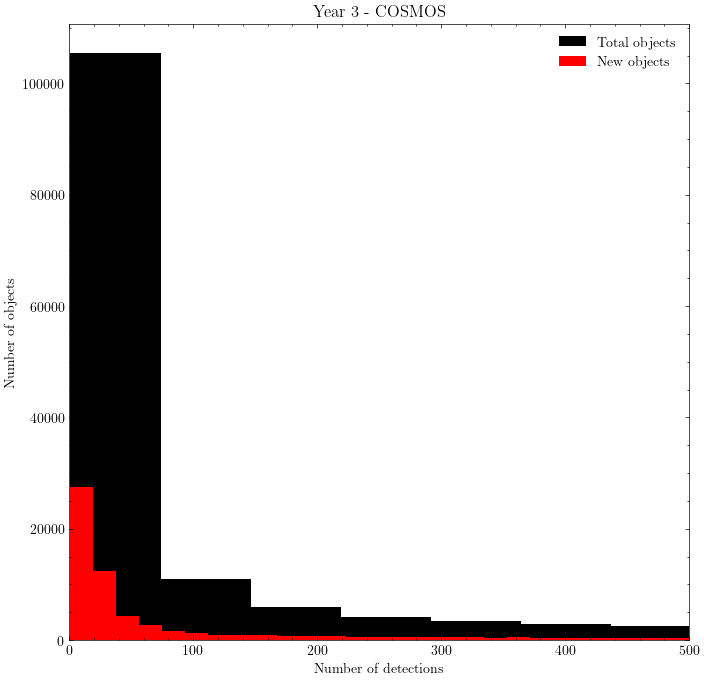

COSMOS
---


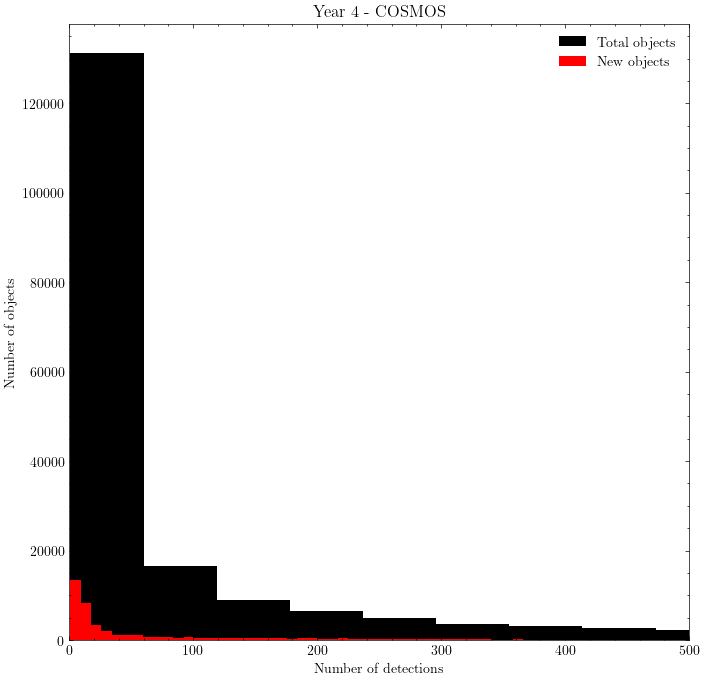

COSMOS
---


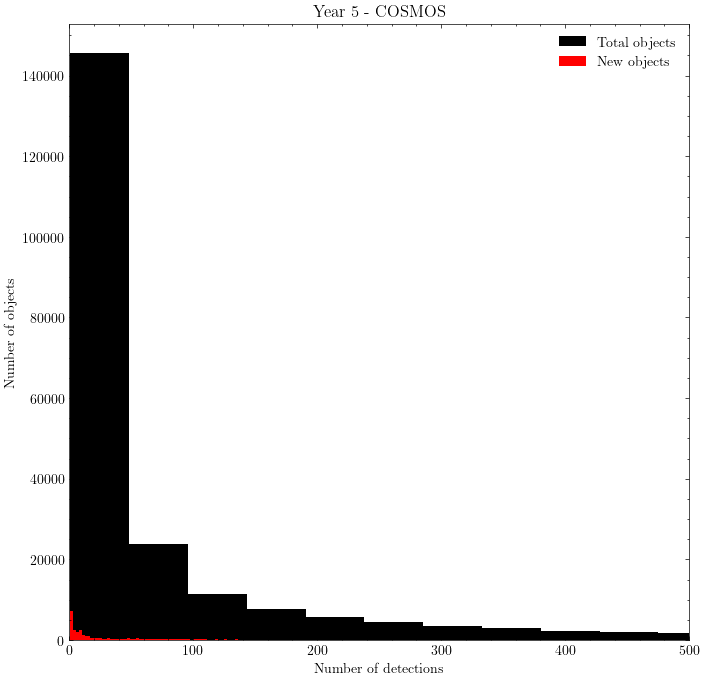

COSMOS
---


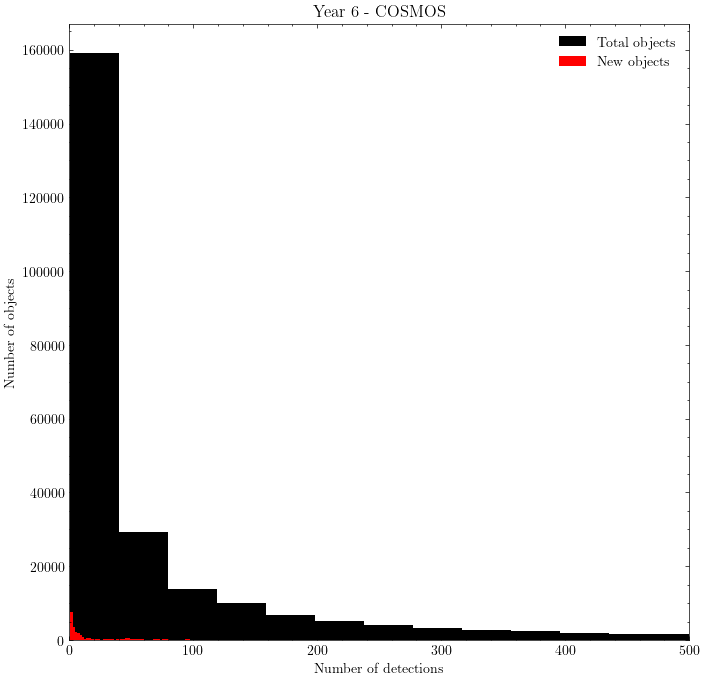

COSMOS
---


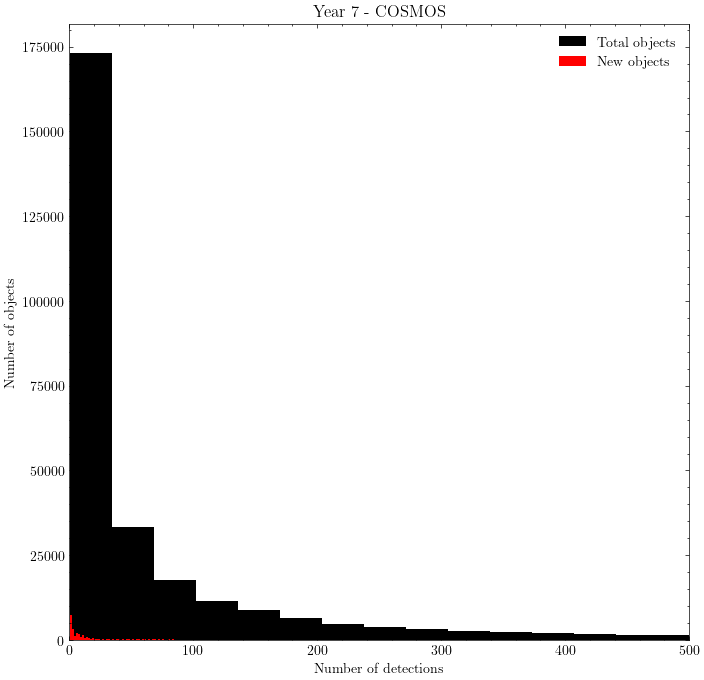

COSMOS
---


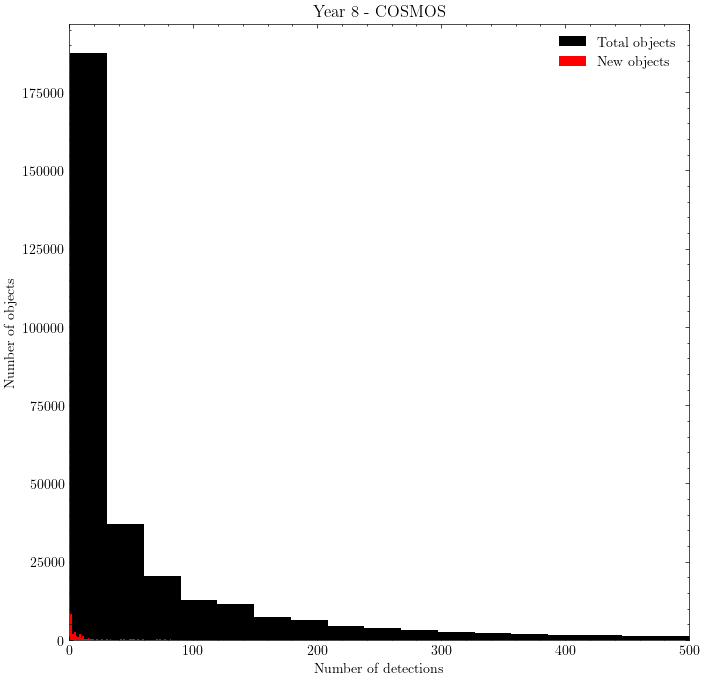

COSMOS
---


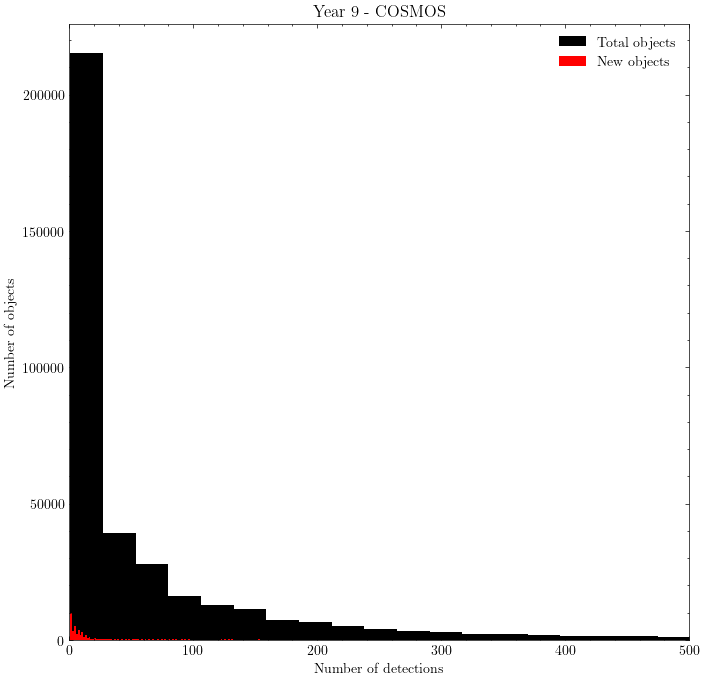

EUCLID SOUTH
---


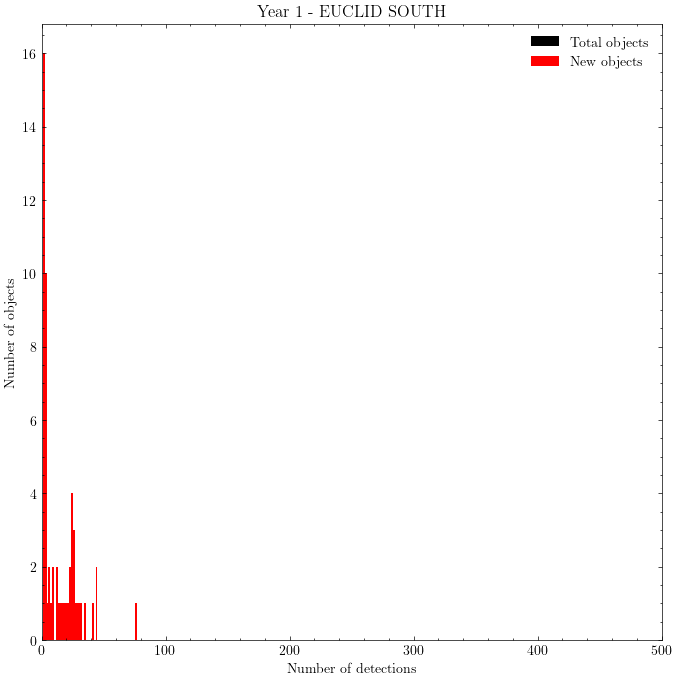

EUCLID SOUTH
---


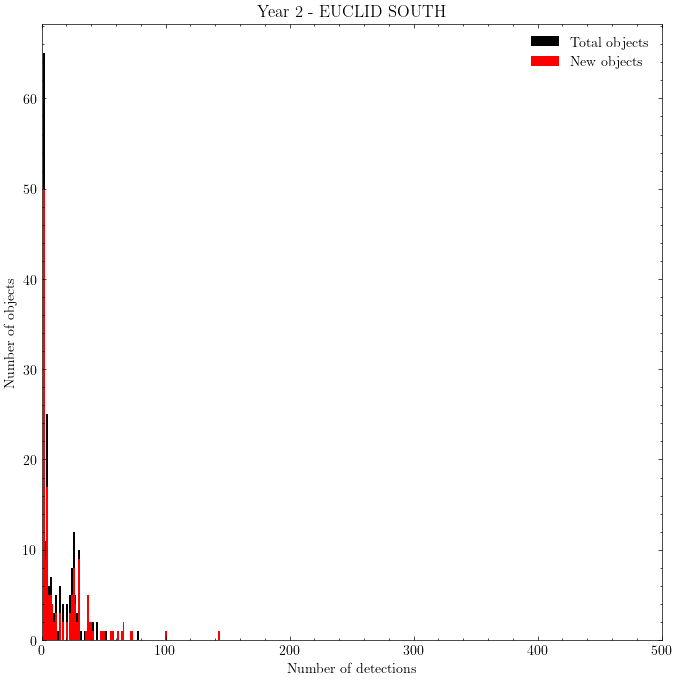

EUCLID SOUTH
---


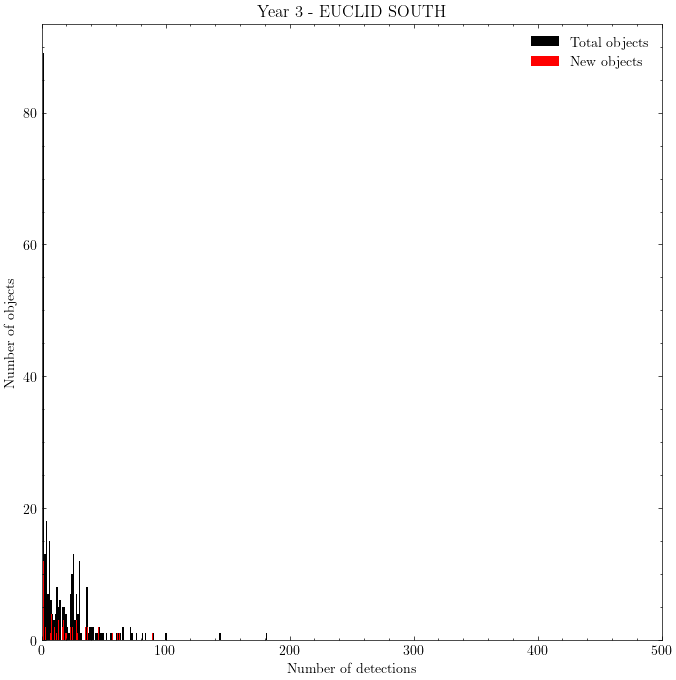

EUCLID SOUTH
---


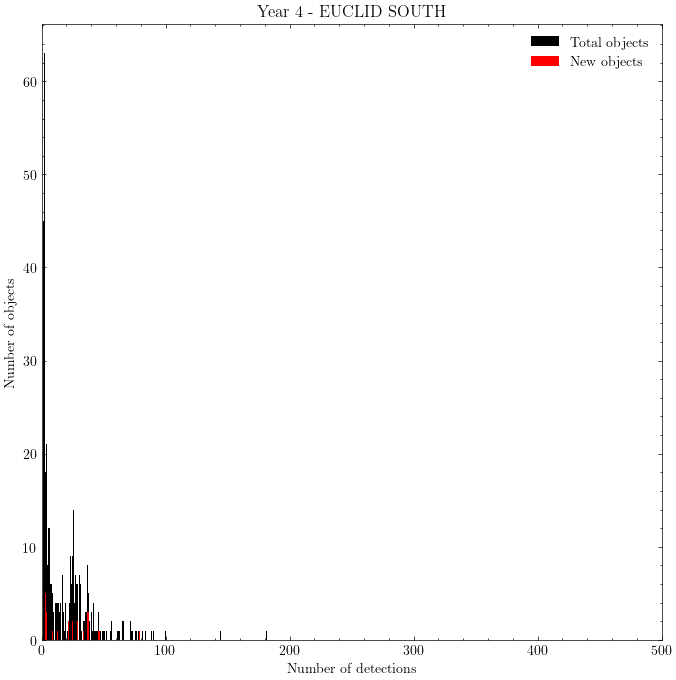

EUCLID SOUTH
---


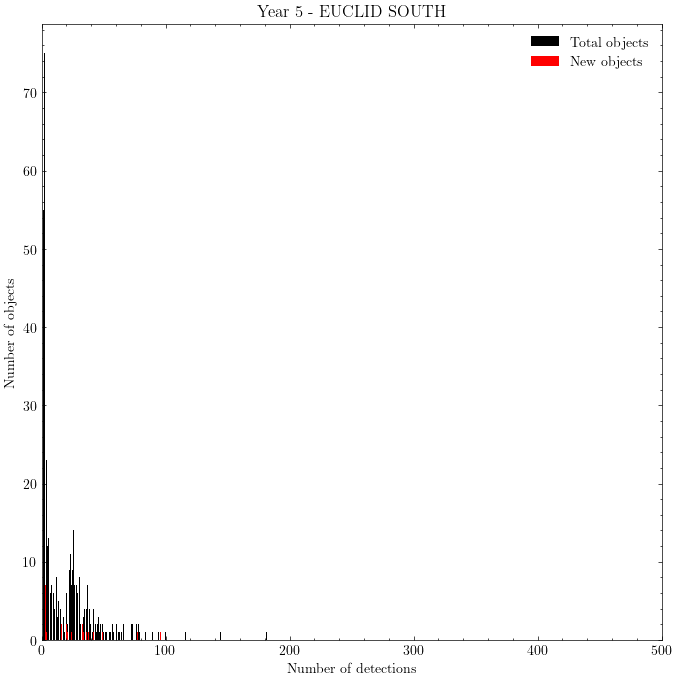

EUCLID SOUTH
---


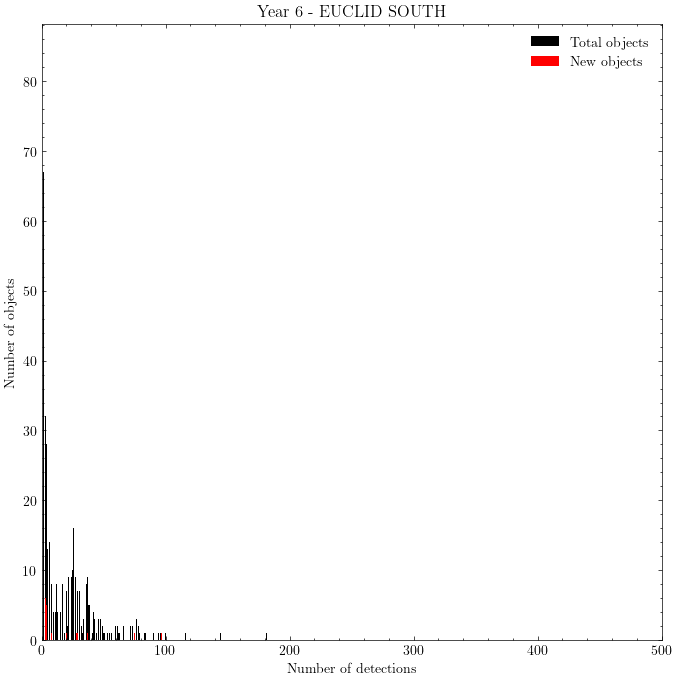

EUCLID SOUTH
---


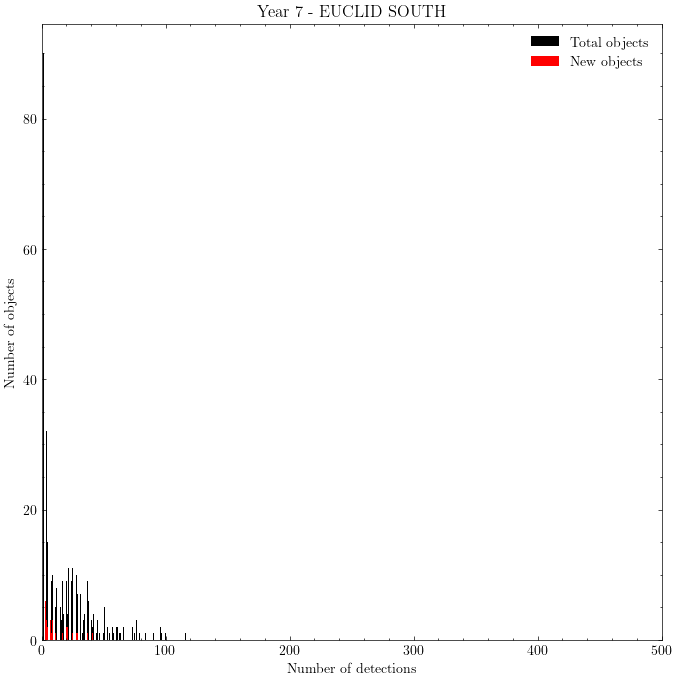

EUCLID SOUTH
---


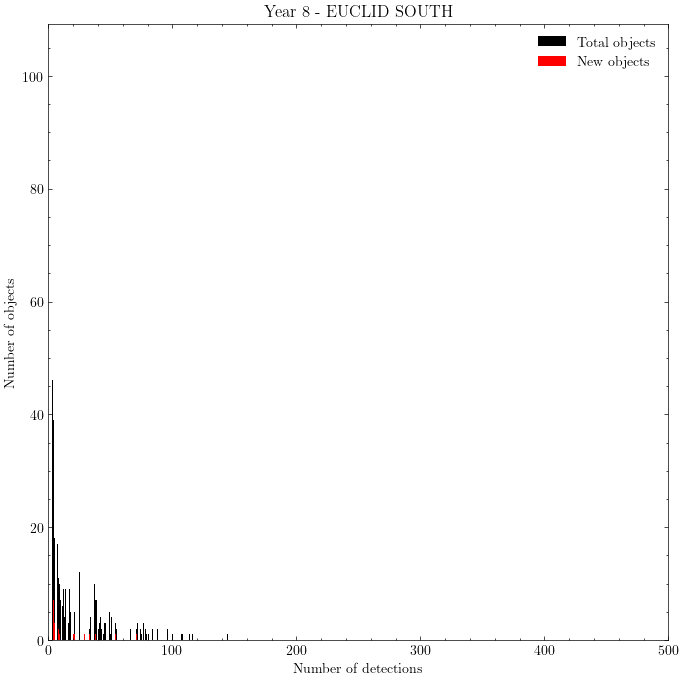

EUCLID SOUTH
---


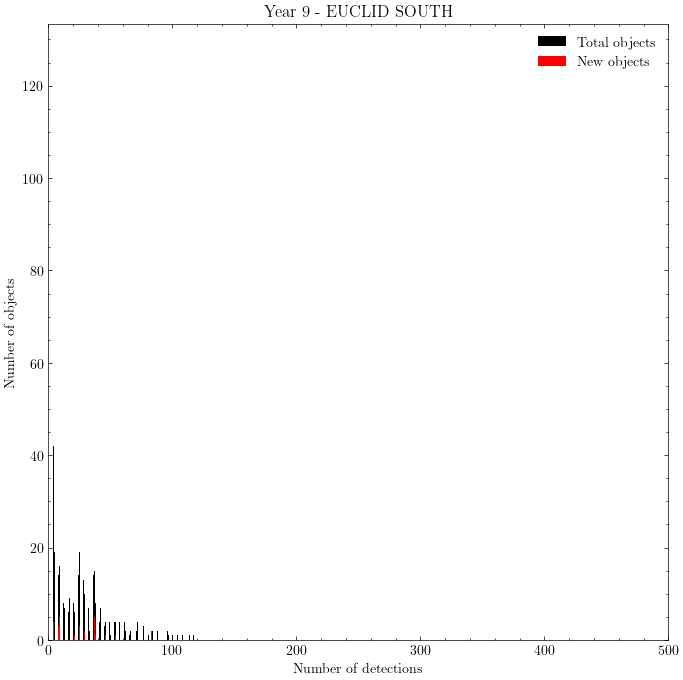

EUCLID NORTH
---


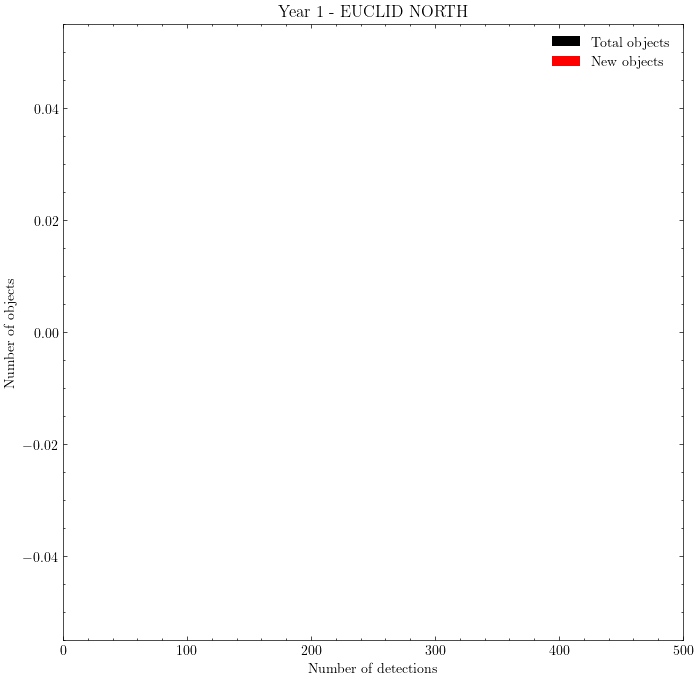

EUCLID NORTH
---


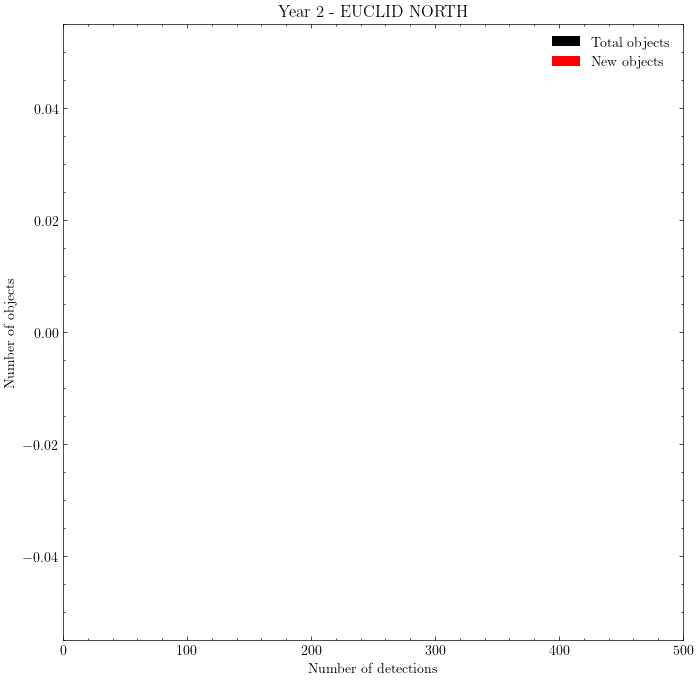

EUCLID NORTH
---


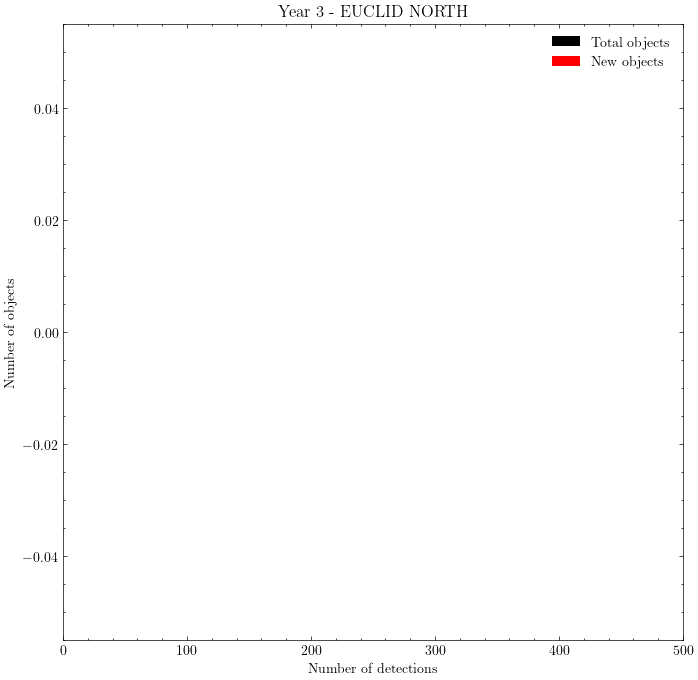

EUCLID NORTH
---


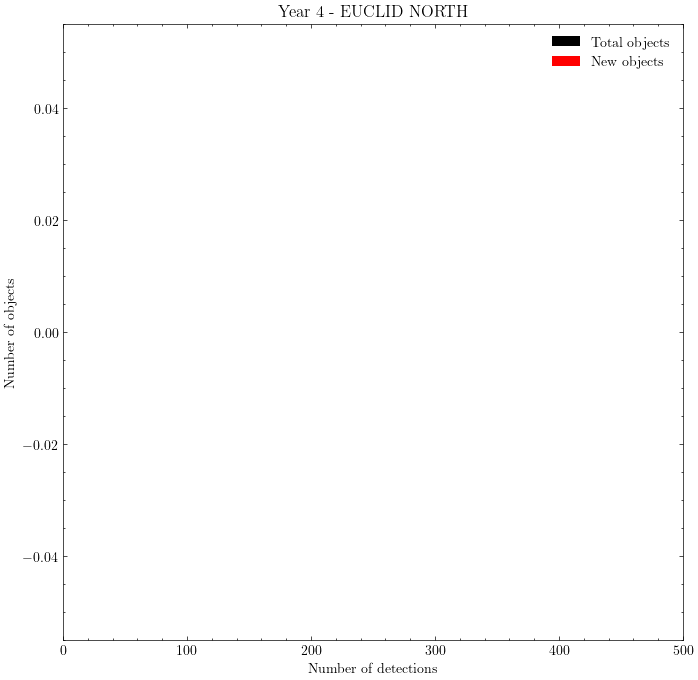

EUCLID NORTH
---


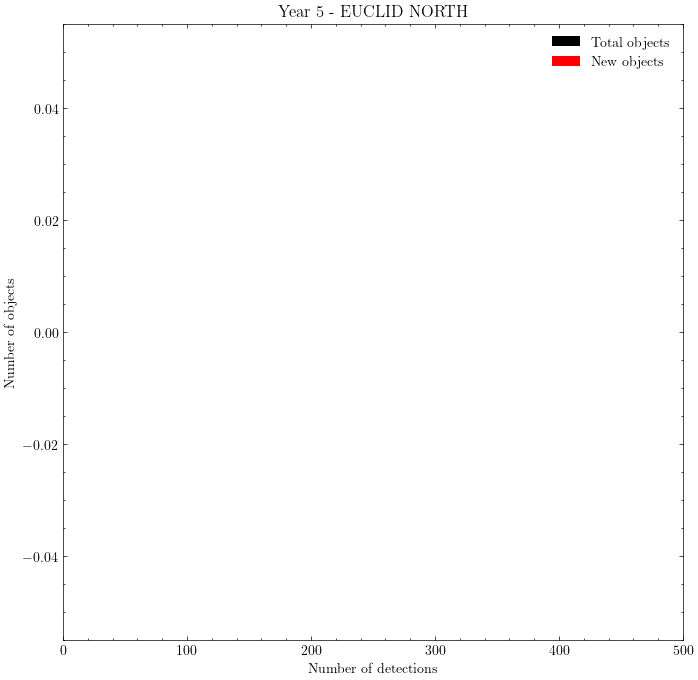

EUCLID NORTH
---


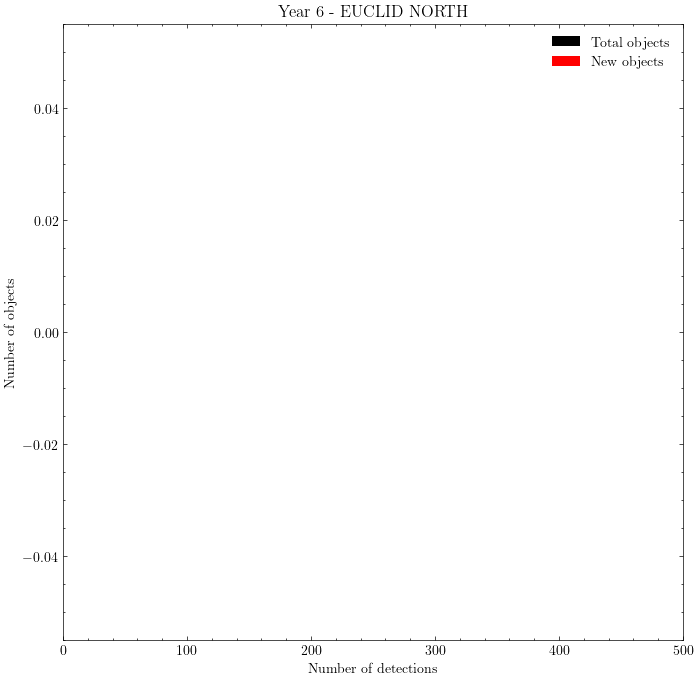

EUCLID NORTH
---


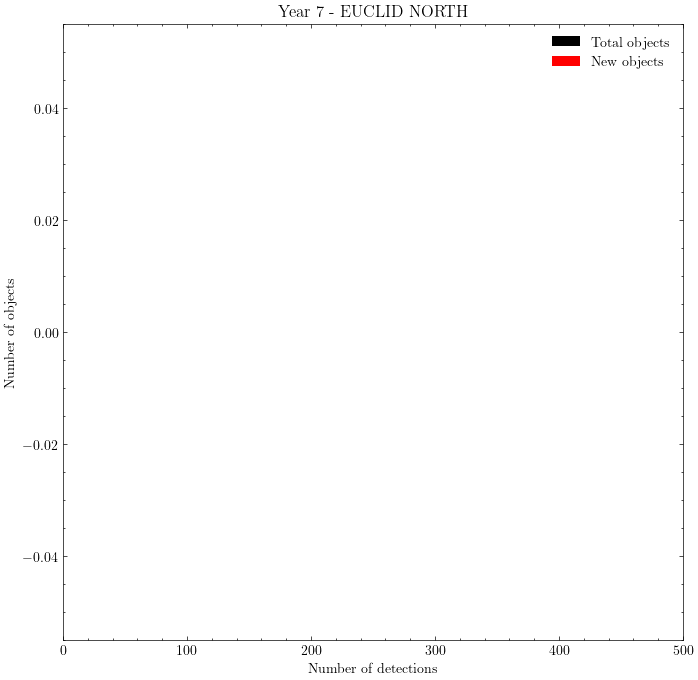

EUCLID NORTH
---


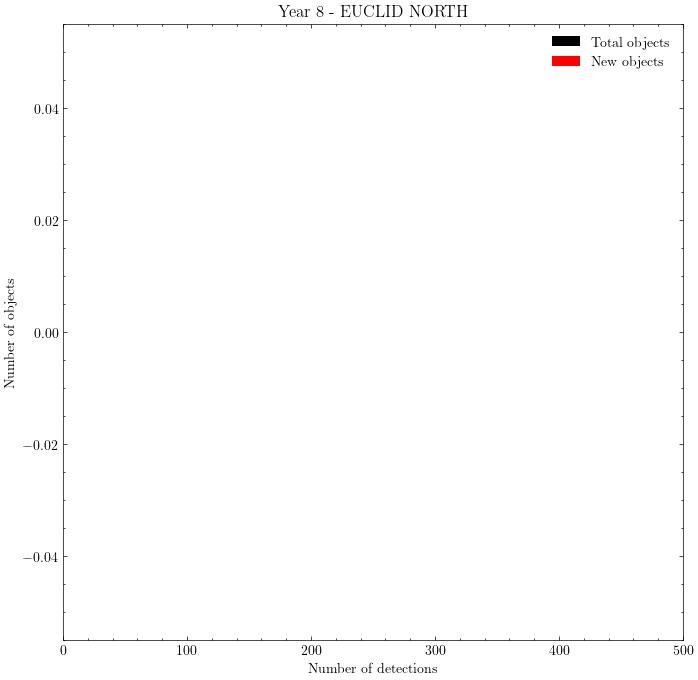

EUCLID NORTH
---


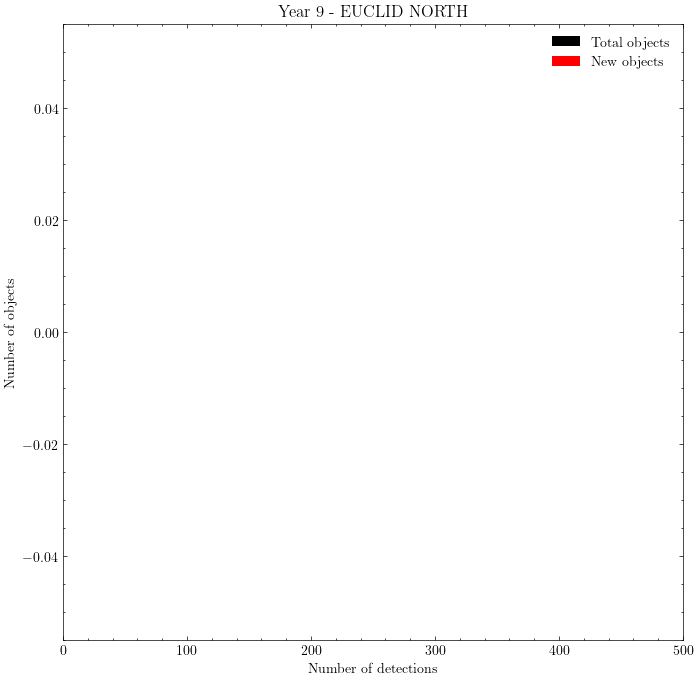

In [72]:
# New objects found in this year.
new_object_counts = []

for name, field in deep_fields.items():
    for i, (date, year) in enumerate(zip(catalog_dates, years)):
        c = SkyCoord(field["ra2000"], field["dec2000"], frame='icrs', unit=(u.hourangle, u.deg))
        print(name)
        print("---")
        stmt = f'''SELECT ssObjectId, count(ssObjectId) as detectionCount, min(midPointMjdTai) as firstDetectionTime
        FROM dp03_catalogs_10yr.DiaSource as ds
        WHERE midPointMjdTai >= {date[0]} and midPointMjdTai <= {date[1]} AND CONTAINS(POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {c.ra.degree}, {c.dec.degree}, 3.5)) = 1
        GROUP BY ssObjectId
        '''
        detection_count = query(stmt)

        dc_df = detection_count.to_table().to_pandas(index=False)
        plt.figure(figsize=(8,8))
        plt.hist(
            dc_df["detectionCount"],
            bins=(i + 1) * 50,
            label="Total objects",
            color="black"
        )
        plt.hist(
            dc_df[dc_df["firstDetectionTime"] >= year[0].value[0]]["detectionCount"],
            bins=(i + 1) * 50,
            label="New objects",
            color="red"
        )

        plt.title(f"Year {i + 1} - {name}")
        plt.xlabel("Number of detections")
        plt.ylabel("Number of objects")
        plt.xlim(0, 500)
        plt.legend()
        plt.show()
        del dc_df

In [15]:
# Basic statistics

In [14]:
for name, field in deep_fields.items():
    for i, (date, year) in enumerate(zip(catalog_dates, years)):
        c = SkyCoord(field["ra2000"], field["dec2000"], frame='icrs', unit=(u.hourangle, u.deg))
        print(name, year)
        print("---")
        
        stmt = f'''SELECT ssObjectId, count(ssObjectId) as detectionCount, min(midPointMjdTai) as firstDetectionTime
        FROM dp03_catalogs_10yr.DiaSource as ds
        WHERE midPointMjdTai >= {date[0]} and midPointMjdTai <= {date[1]} AND CONTAINS(POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {c.ra.degree}, {c.dec.degree}, 3.5)) = 1
        GROUP BY ssObjectId
        '''
        detection_count = query(stmt)

        dc_df = detection_count.to_table().to_pandas(index=False)

        print("Object detection statistics")
        print("***")
        print(dc_df.describe())
        print("\n")
        print("New object detection statistics")
        print("***")
        print(dc_df[dc_df["firstDetectionTime"] >= year[0].value[0]].describe())

        del dc_df

ELAIS S1 [[60218.00491   ]
 [60594.04429841]]
---
Object detection statistics
***
         ssObjectId  detectionCount  firstDetectionTime
count  7.080000e+02      708.000000          708.000000
mean   1.639337e+17       42.261299        60453.235333
std    5.273834e+18       44.105676          151.312907
min   -9.212450e+18        1.000000        60218.051140
25%   -4.230708e+18        6.000000        60259.008530
50%    1.625553e+17       24.000000        60540.419025
75%    4.564264e+18       72.000000        60564.317090
max    9.196705e+18      213.000000        60592.990090


New object detection statistics
***
         ssObjectId  detectionCount  firstDetectionTime
count  7.080000e+02      708.000000          708.000000
mean   1.639337e+17       42.261299        60453.235333
std    5.273834e+18       44.105676          151.312907
min   -9.212450e+18        1.000000        60218.051140
25%   -4.230708e+18        6.000000        60259.008530
50%    1.625553e+17       24.000000     